# Analisando o bot

Este jupyter-notebook vai auxiliar na análise de um RASA bot.

## Instalação

### Configurando jupyter

In [1]:
%matplotlib inline

import logging, io, json, warnings
logging.basicConfig(level="INFO")
warnings.filterwarnings('ignore')

def pprint(o):
    # small helper to make dict dumps a bit prettier
    print(json.dumps(o, indent=2))

### Instalação do Rasa


In [5]:
import sys
python = sys.executable

# In your environment run:
!{python} -m pip install -U rasa_core==0.9.0a7 rasa_nlu[spacy];

# as well as install a language model:
!{python} -m spacy download pt;

Requirement already up-to-date: rasa_core==0.9.0a7 in /home/arthur/.pyenv/versions/3.6.6/lib/python3.6/site-packages (0.9.0a7)
Requirement already up-to-date: rasa_nlu[spacy] in /home/arthur/.pyenv/versions/3.6.6/lib/python3.6/site-packages (0.13.7)


    100% |████████████████████████████████| 38.7MB 376kB/s ta 0:00:012  5% |█▉                              | 2.2MB 45.5MB/s eta 0:00:01    51% |████████████████▍               | 19.9MB 228kB/s eta 0:01:23
  Running setup.py install for pt-core-news-sm ... done

    Linking successful
    /home/arthur/.pyenv/versions/3.6.6/lib/python3.6/site-packages/pt_core_news_sm
    -->
    /home/arthur/.pyenv/versions/3.6.6/lib/python3.6/site-packages/spacy/data/pt

    You can now load the model via spacy.load('pt')



Verificando versões:

In [7]:
import rasa_nlu
import rasa_core
import spacy

print("rasa_nlu: {} rasa_core: {}".format(rasa_nlu.__version__, rasa_core.__version__))
print("Loading spaCy language model...")
print(spacy.load("pt")("Olá Mundo!"))

rasa_nlu: 0.13.7 rasa_core: 0.9.0a7
Loading spaCy language model...
Olá Mundo!


### Ferramentas adicionais

Atualize a instalação de acordo com seu sistema operacional

In [8]:
#!apt-get -qq install -y graphviz libgraphviz-dev pkg-config;
#!brew install graphviz;

In [9]:
!{python} -m pip install pygraphviz;

### NLU Pipeline

Criando um pipeline de nlu para o bot.

`Caso queira testar diferentes algoritmos/modelos dentro do RASA nlu, mude a celula seguinte.`

In [13]:
config = """
language: "pt"

pipeline:
- name: "nlp_spacy"                   # loads the spacy language model
- name: "tokenizer_spacy"             # splits the sentence into tokens
- name: "ner_spacy"                   # uses the pretrained spacy NER model
- name: "intent_featurizer_spacy"     # transform the sentence into a vector representation
- name: "intent_classifier_sklearn"   # uses the vector representation to classify using SVM
""" 

%store config > config.yml

Writing 'config' (str) to file 'config.yml'.


## Adicionando nlu (natural language understanding)

Nesta parte o bot vai aprender a entender a linguagem

### Treinando o modelo do Rasa NLU

In [14]:
import os

from rasa_nlu.training_data import load_data
from rasa_nlu.config import RasaNLUModelConfig
from rasa_nlu.model import Trainer
from rasa_nlu import config


intents_directory = 'intents/'

intents = {}

for intent_file in os.listdir(intents_directory):
    intent_file_path = os.path.join(intents_directory, intent_file)

    intents[intent_file] = {}

    intent_list = []
    intent_name = None

    with open(intent_file_path) as f:
        lines = f.readlines()

        for line in lines:
            line = line.strip()

            if line.startswith('##'):
                if intent_name is not None:
                    intents[intent_file][intent_name] = intent_list
                intent_name = line.replace('## intent:', '') 
                intent_list = []

            elif line.startswith('- '):
                intent_list.append(line.replace('- ', ''))


# loading the nlu training samples
training_data = load_data(intents_directory)

# trainer to educate our pipeline
trainer = Trainer(config.load("config.yml"))

# train the model!
interpreter = trainer.train(training_data)

# store it for future use
model_directory = trainer.persist("./models/nlu", fixed_model_name="current")

INFO:rasa_nlu.training_data.loading:Training data format of intents/prazo.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 19 (1 distinct intents)
	- Found intents: 'escolher_prazo'
	- entity examples: 0 (0 distinct entities)
	- found entities: 

INFO:rasa_nlu.training_data.loading:Training data format of intents/geral.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 230 (8 distinct intents)
	- Found intents: 'duvida_sobre_contexto', 'afirmar_curiosidades', 'negar', 'afirmar_projeto', 'afirmar', 'o_que_eh', 'extra', 'cumprimentar'
	- entity examples: 0 (0 distinct entities)
	- found entities: 

INFO:rasa_nlu.training_data.loading:Training data format of intents/preenchimento.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 14 (1 distinct intents)
	- Found intents: 'escolher_preenchimento'
	- entity examples: 0 (0 distinct entities)
	- found entities: 

INF

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    2.7s finished
INFO:rasa_nlu.model:Finished training component.
INFO:rasa_nlu.model:Successfully saved model into '/home/arthur/Documents/lappis/bot/rasa-demo-pydata18/tais/models/nlu/default/current'


### Avaliação do modelo de NLU treinado

`Caso queira testar mensagens específicas mande a mensagem na célula seguinte`

In [15]:
pprint(interpreter.parse("sim"))

{
  "intent": {
    "name": "afirmar",
    "confidence": 0.578982565518625
  },
  "entities": [],
  "intent_ranking": [
    {
      "name": "afirmar",
      "confidence": 0.578982565518625
    },
    {
      "name": "extra",
      "confidence": 0.166814657446867
    },
    {
      "name": "cumprimentar",
      "confidence": 0.09972043723416238
    },
    {
      "name": "negar",
      "confidence": 0.09779607190160797
    },
    {
      "name": "escolher_processo",
      "confidence": 0.011505015801792534
    },
    {
      "name": "escolher_preenchimento",
      "confidence": 0.009845459790614098
    },
    {
      "name": "escolher_prazo",
      "confidence": 0.008381757875823221
    },
    {
      "name": "duvida_sobre_contexto",
      "confidence": 0.007599752609912967
    },
    {
      "name": "afirmar_curiosidades",
      "confidence": 0.003048782697303526
    },
    {
      "name": "escolher_erros_salic",
      "confidence": 0.0028307980958610815
    }
  ],
  "text": "sim"
}


### Avaliação de correlação das intents

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-pt'.
INFO:rasa_nlu.training_data.loading:Training data format of intents/geral.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 230 (8 distinct intents)
	- Found intents: 'duvida_sobre_contexto', 'afirmar_curiosidades', 'negar', 'afirmar_projeto', 'afirmar', 'o_que_eh', 'extra', 'cumprimentar'
	- entity examples: 0 (0 distinct entities)
	- found entities: 

INFO:rasa_nlu.evaluate:Intent evaluation results:
INFO:rasa_nlu.evaluate:Intent Evaluation: Only considering those 230 examples that have a defined intent out of 230 examples
INFO:rasa_nlu.evaluate:F1-Score:  0.9729347826086957
INFO:rasa_nlu.evaluate:Precision: 0.9763928846387616
INFO:rasa_nlu.evaluate:Accuracy:  0.9739130434782609
INFO:rasa_nlu.evaluate:Classification report: 
                       precision    recall  f1-score   support

              afirmar       0.89      1.00      0.94        33
 afirmar_c

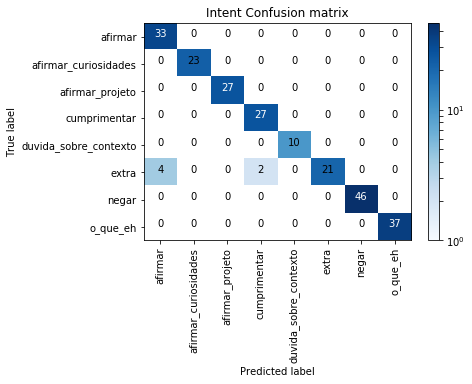

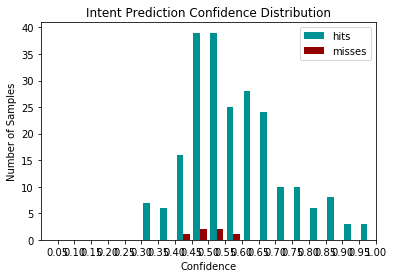

INFO:rasa_nlu.evaluate:Entity evaluation results:
INFO:rasa_nlu.evaluate:Evaluation for entity extractor: ner_spacy 
INFO:rasa_nlu.evaluate:F1-Score:  0.9817708333333335
INFO:rasa_nlu.evaluate:Precision: 1.0
INFO:rasa_nlu.evaluate:Accuracy:  0.9641943734015346
INFO:rasa_nlu.evaluate:Classification report: 
             precision    recall  f1-score   support

        LOC       0.00      0.00      0.00         0
       MISC       0.00      0.00      0.00         0
        ORG       0.00      0.00      0.00         0
        PER       0.00      0.00      0.00         0
  no_entity       1.00      0.96      0.98       782

avg / total       1.00      0.96      0.98       782



In [18]:
from rasa_nlu.evaluate import run_evaluation

run_evaluation("intents/geral.md", model_directory)

# RASA core

`Adicionando stories`

### Definindo Contexto (domain)

### Visualização do fluxo de conversa

In [19]:
from IPython.display import Image
from rasa_core.agent import Agent

agent = Agent('domain.yml')
agent.visualize("stories.md", "story_graph.png", max_history=2)
Image(filename="story_graph.png")

INFO:apscheduler.scheduler:Scheduler started


ValueError: Action 'actions.actions_oqueeh.ActionOQueEh' doesn't correspond to a template / action. Remember to prefix actions that should utter a template with `utter_`. Error: No module named 'actions'

### Treinando o modelo de diálogo

`Para verificar possíveis melhorias no comportamento do bot mude a célula a seguir`

**importante** após identifcar melhorias atualize o arquivo de treinho do bot `train.py`

In [43]:
from rasa_core.policies import FallbackPolicy, KerasPolicy, MemoizationPolicy
from rasa_core.agent import Agent

# this will catch predictions the model isn't very certain about
# there is a threshold for the NLU predictions as well as the action predictions
fallback = FallbackPolicy(fallback_action_name="utter_unclear",
                          core_threshold=0.2,
                          nlu_threshold=0.6)

agent = Agent('domain.yml', policies=[MemoizationPolicy(), KerasPolicy(), fallback])

# loading our neatly defined training dialogues
training_data = agent.load_data('stories.md')

agent.train(
    training_data,
    validation_split=0.0,
    epochs=400
)

agent.persist('models/dialogue')

Processed Story Blocks: 100%|██████████| 6/6 [00:00<00:00, 140.95it/s, # trackers=20]
Processed actions: 171it [00:00, 669.21it/s, # examples=171]
INFO:rasa_core.policies.memoization:Memorized 171 unique action examples.
INFO:rasa_core.policies.keras_policy:Fitting model with 171 total samples and a validation split of 0.0


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_3 (Masking)          (None, 5, 15)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                6144      
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 297       
_________________________________________________________________
activation_3 (Activation)    (None, 9)                 0         
Total params: 6,441
Trainable params: 6,441
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
171/171 [==============================] - 1s 5ms/step - loss: 2.1807 - acc: 0.1053
Epoch 2/400
171/171 [==============================] - 0s 159us/step - loss: 2.0990 - acc: 0.4152
Epoch 3/400
171/171 [==============================] - 0s 161us/step - loss: 2

171/171 [==============================] - 0s 254us/step - loss: 0.1108 - acc: 0.9883
Epoch 158/400
171/171 [==============================] - 0s 255us/step - loss: 0.1297 - acc: 0.9708
Epoch 159/400
171/171 [==============================] - 0s 218us/step - loss: 0.0924 - acc: 0.9883
Epoch 160/400
171/171 [==============================] - 0s 293us/step - loss: 0.0770 - acc: 1.0000
Epoch 161/400
171/171 [==============================] - 0s 213us/step - loss: 0.1237 - acc: 0.9766
Epoch 162/400
171/171 [==============================] - 0s 215us/step - loss: 0.1019 - acc: 0.9825
Epoch 163/400
171/171 [==============================] - 0s 251us/step - loss: 0.1235 - acc: 0.9591
Epoch 164/400
171/171 [==============================] - 0s 226us/step - loss: 0.1121 - acc: 0.9825
Epoch 165/400
171/171 [==============================] - 0s 243us/step - loss: 0.0915 - acc: 0.9883
Epoch 166/400
171/171 [==============================] - 0s 221us/step - loss: 0.0906 - acc: 0.9766
Epoch 167/400


171/171 [==============================] - 0s 198us/step - loss: 0.0458 - acc: 0.9942
Epoch 240/400
171/171 [==============================] - 0s 226us/step - loss: 0.0231 - acc: 1.0000
Epoch 241/400
171/171 [==============================] - 0s 134us/step - loss: 0.0487 - acc: 0.9883
Epoch 242/400
171/171 [==============================] - 0s 136us/step - loss: 0.0505 - acc: 0.9883
Epoch 243/400
171/171 [==============================] - 0s 321us/step - loss: 0.0355 - acc: 1.0000
Epoch 244/400
171/171 [==============================] - 0s 393us/step - loss: 0.0908 - acc: 0.9708
Epoch 245/400
171/171 [==============================] - 0s 194us/step - loss: 0.0736 - acc: 0.9883
Epoch 246/400
171/171 [==============================] - 0s 158us/step - loss: 0.0634 - acc: 0.9825
Epoch 247/400
171/171 [==============================] - 0s 189us/step - loss: 0.0524 - acc: 0.9942
Epoch 248/400
171/171 [==============================] - 0s 231us/step - loss: 0.0315 - acc: 1.0000
Epoch 249/400


171/171 [==============================] - 0s 218us/step - loss: 0.0537 - acc: 0.9825
Epoch 322/400
171/171 [==============================] - 0s 119us/step - loss: 0.0162 - acc: 1.0000
Epoch 323/400
171/171 [==============================] - 0s 160us/step - loss: 0.0307 - acc: 0.9942
Epoch 324/400
171/171 [==============================] - 0s 143us/step - loss: 0.0359 - acc: 0.9942
Epoch 325/400
171/171 [==============================] - 0s 122us/step - loss: 0.0289 - acc: 0.9942
Epoch 326/400
171/171 [==============================] - 0s 114us/step - loss: 0.0267 - acc: 1.0000
Epoch 327/400
171/171 [==============================] - 0s 119us/step - loss: 0.0352 - acc: 0.9942
Epoch 328/400
171/171 [==============================] - 0s 112us/step - loss: 0.0215 - acc: 1.0000
Epoch 329/400
171/171 [==============================] - 0s 107us/step - loss: 0.0189 - acc: 1.0000
Epoch 330/400
171/171 [==============================] - 0s 120us/step - loss: 0.0253 - acc: 1.0000
Epoch 331/400


INFO:rasa_core.policies.keras_policy:Done fitting keras policy model
INFO:rasa_core.agent:Model directory models/dialogue exists and contains old model files. All files will be overwritten.
INFO:rasa_core.agent:Persisted model to '/home/arthur/Documents/lappis/bot/rasa-demo-pydata18/models/dialogue'


### Inicializando bot completo (core+nlu)

In [44]:
from rasa_core.agent import Agent
agent = Agent.load('models/dialogue', interpreter=model_directory)

INFO:rasa_nlu.components:Added 'nlp_spacy' to component cache. Key 'nlp_spacy-en'.


### Testando conversação

In [45]:
print("Converse com o bot, diga 'stop' para encerrar teste.")
while True:
    a = input()
    if a == 'stop':
        break
    responses = agent.handle_message(a)
    for response in responses:
        print(response["text"])


Converse com o bot, diga 'stop' para encerrar teste.
stop


### Avaliação do modelo de diálogo (`stories`)

Processed Story Blocks: 100%|██████████| 6/6 [00:00<00:00, 1871.90it/s]
INFO:rasa_core.evaluate:Evaluating 6 stories
Progress:
100%|██████████| 6/6 [00:00<00:00, 27.54it/s]
INFO:rasa_nlu.evaluate:F1-Score:  1.0
INFO:rasa_nlu.evaluate:Precision: 1.0
INFO:rasa_nlu.evaluate:Accuracy:  1.0
INFO:rasa_nlu.evaluate:Classification report: 
                       precision    recall  f1-score   support

        action_listen       1.00      1.00      1.00        13
action_retrieve_image       1.00      1.00      1.00         2
       utter_cheer_up       1.00      1.00      1.00         2
  utter_did_that_help       1.00      1.00      1.00         2
        utter_goodbye       1.00      1.00      1.00         3
          utter_greet       1.00      1.00      1.00         3
          utter_happy       1.00      1.00      1.00         4
        utter_unclear       1.00      1.00      1.00         1

          avg / total       1.00      1.00      1.00        30

INFO:rasa_nlu.evaluate:Confusion 

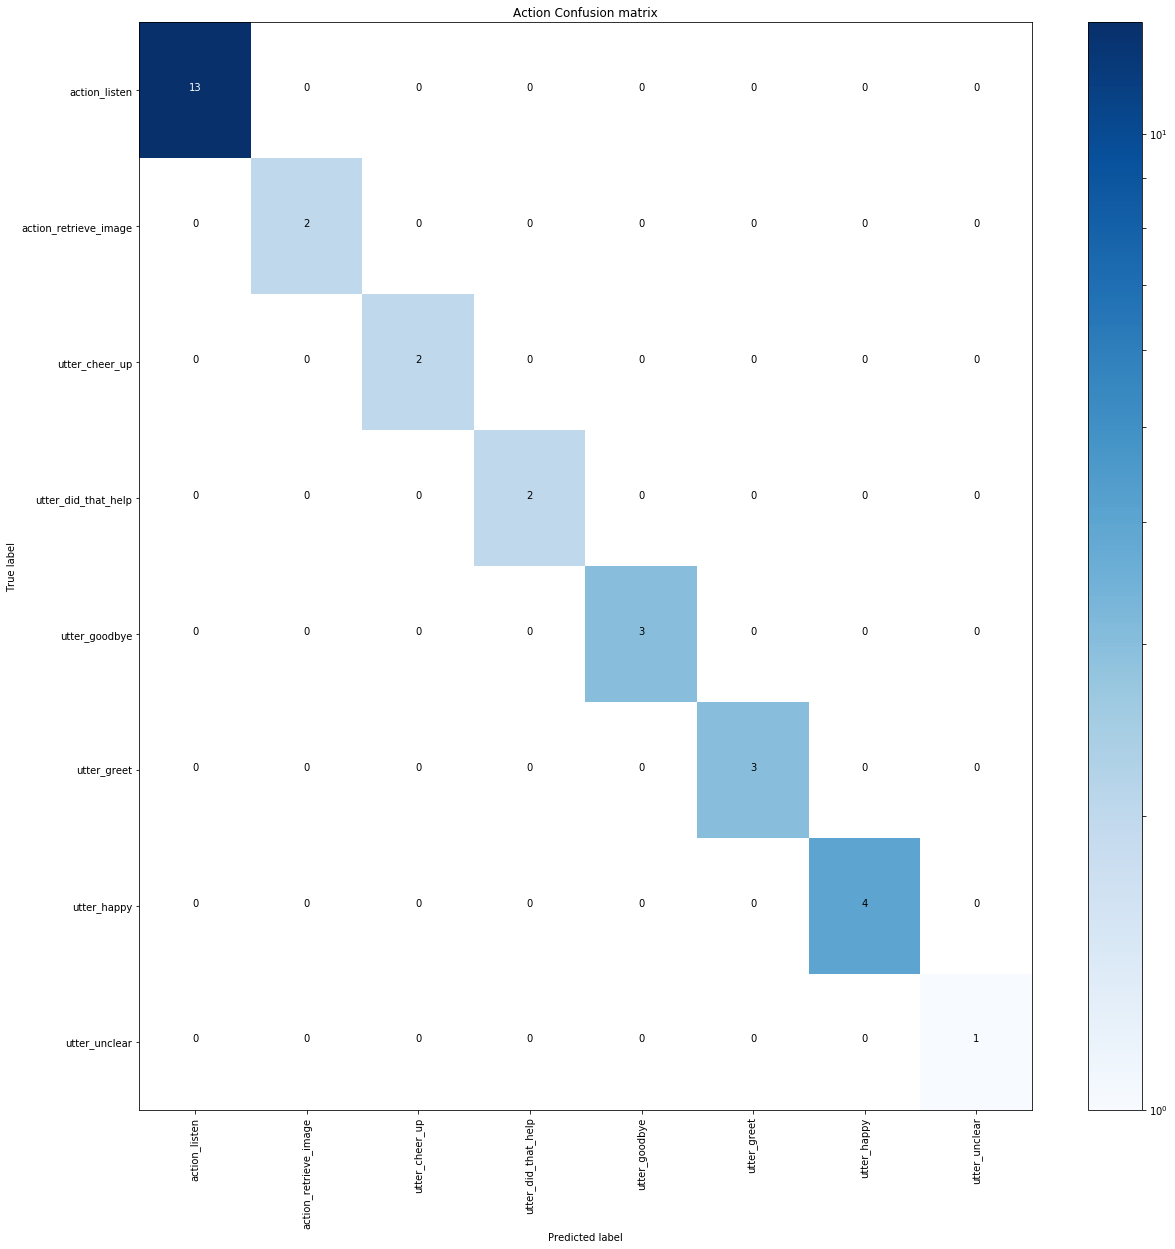

In [46]:
from rasa_core.evaluate import run_story_evaluation

run_story_evaluation("stories.md", "models/dialogue", 
                     nlu_model_path=None, 
                     max_stories=None, 
                     out_file_plot="story_eval.pdf")